In [1]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from geocube.api.core import make_geocube
import rasterio as rio
import scipy.stats as stats
import numpy as np
from datetime import datetime, date
import math
import random
from matplotlib import colors
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [2]:
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [3]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.metrics import confusion_matrix

In [4]:
import verde as vd # Use verde library (good for spatial problems)

In [5]:
# Load data 
data0616 = pd.read_csv('/users/aleclerc/work/drive/data_portugal_static_0616_imp.csv')
data1722 = pd.read_csv('/users/aleclerc/work/drive/data_portugal_static_1722_imp.csv')

In [6]:
print(data0616['burned_areas'].sum())
print(data1722['burned_areas'].sum())

19226
13319


In [7]:
# Down-sampling to obtain balanced data 
ones_1 = data0616[data0616['burned_areas']==1.0] 
zeros_1 = data0616[data0616['burned_areas']==0]
ones_2 = data1722[data1722['burned_areas']==1.0] 
zeros_2 = data1722[data1722['burned_areas']==0]
sample_1 = zeros_1.sample(n=20000, random_state=13) # n = 20000 which is close to 19226
sample_2 = zeros_2.sample(n=14000, random_state=13) # n = 14000 which is cloe to 133319
data0616 = pd.concat([ones_1, sample_1], ignore_index=True)
data1722 = pd.concat([ones_2, sample_2], ignore_index=True)
print(data0616.shape)
print(data1722.shape)

(39226, 24)
(27319, 24)


In [8]:
# Drop unwanted columns
unwanted = ['x','y','population_mean','lc_agriculture_mean','lc_forest_mean','lc_grassland_mean'] 
data_0616 = data0616.drop(columns=unwanted)
data_1722 = data1722.drop(columns=unwanted)

In [9]:
# Get input and output 
input = data_0616.drop('burned_areas', axis=1)
output = data_0616['burned_areas']
X = input.to_numpy()
Y = output.to_numpy()
unseen_tst = data_1722.drop('burned_areas', axis=1)
print(unseen_tst.head(1))
unseen_test = data_1722.drop('burned_areas', axis=1).to_numpy()
Y_unseen_test = data_1722['burned_areas'].to_numpy()
Y_test = data_1722['burned_areas']

   d2m_mean  lst_day_mean  lst_night_mean  ndvi_mean   rh_mean  smi_mean  \
0  284.2035      294.1443        284.3627   0.674606  0.599794   0.73179   

     sp_mean  ssrd_mean   t2m_mean  tp_mean  wind_direction_mean  \
0  95720.836  7582142.0  290.58185   0.0053            190.26793   

   wind_speed_mean        dem    aspect  curvature  roads_distance      slope  
0          3.04619  200.98283  325.4923    8346.08           0.653  10.740703  


In [10]:
# Coordinates and spatial folds 
coordinates = data0616[["x","y"]].to_numpy()
spacing = 0.3 # The spacing parameter can be changed 
n_splits = 5
random_state = 13
cv = vd.BlockKFold(spacing=spacing,n_splits=n_splits,shuffle=True,balance=True,random_state=random_state) # Initiate spatial folds
# shuffle=False is better when dealing with spatial autocorrelation
# balance=True to increase the odd of getting folds of similar sizes 
print(coordinates.shape)
print(coordinates[:2])

(39226, 2)
[[-8.24213027 42.13109855]
 [-8.2320613  42.13109855]]


In [11]:
# Define the parameter distributions (to be adjusted)
param_dist = {'n_estimators': np.arange(1,100,2),
              'max_depth': np.arange(1,50,1), 'max_features': ['sqrt', 'log2', None, 0.5, 0.75]}

In [12]:
from sklearn.utils.class_weight import compute_sample_weight

# Calculate the distribution of the target variable in both training and testing datasets
train_target_dist = output.value_counts(normalize=True)
test_target_dist = Y_test.value_counts(normalize=True)

# Calculate the class weights to adjust for label shift
class_weights = {0: test_target_dist[0] / train_target_dist[0],
                 1: test_target_dist[1] / train_target_dist[1]}
sample_weights = output.map(class_weights)
print(sample_weights.shape)
print(Y_test.shape)
num = X.shape[0]
print(num)
print(test_target_dist[0])
print(train_target_dist[0])
print(test_target_dist[1])
print(train_target_dist[1])

(39226,)
(27319,)
39226
0.5124638529960833
0.5098659052669148
0.4875361470039167
0.4901340947330852


In [13]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from scipy.stats import randint

# Convert splits to a list
folds = list(cv.split(coordinates))

# Create an array to store fold numbers (initialize with -1 for all points)
fold_labels = -1 * np.ones(len(coordinates), dtype=int)

# Assign each point to its corresponding test fold
for fold_number, (train_idx, test_idx) in enumerate(folds):
    fold_labels[test_idx] = fold_number  # Assign fold number to test set

# Create a random forest classifier
rf = RandomForestClassifier(random_state=13)

#cv_no_spatial = ShuffleSplit(n_splits=1, test_size=0.2, random_state=13)

# Use RandomizedSearchCV to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 n_iter=5,           # Number of random combinations to try
                                 cv=folds,               # 5-fold cross-validation
                                 verbose=1,          # Show progress during the search
                                 random_state=13)    # Set random state for reproducibility

# Fit the randomized search to find the best hyperparameters
rand_search.fit(X, Y, sample_weight=sample_weights)
best_params = rand_search.best_params_  # Store best hyperparameters

# Get optimized model
best_rf = RandomForestClassifier(**best_params, random_state=13)

# Prepare arrays for out-of-fold predictions
n_samples, n_features = X.shape
oof_X_test = np.full((n_samples, n_features), np.nan)
oof_proba = np.full(n_samples, np.nan)
oof_true = np.full(n_samples, np.nan, dtype=Y.dtype)
oof_proba_original = np.full(n_samples, np.nan, dtype=float)

# List to store performance metrics for each fold
accuracies = []

# Iterate through the folds and train/evaluate the model
for fold_number, (train_idx, test_idx) in enumerate(folds):
    # Split data into training and testing based on fold indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    sample_weights2 = sample_weights.sample(n=X_train.shape[0], random_state=89)

    best_rf.fit(X_train, y_train, sample_weight=sample_weights2)

    # Predict on the test set
    y_pred = best_rf.predict(X_test)
    y_proba = best_rf.predict_proba(X_test)[:, 1]

    # Save OOF results
    oof_X_test[test_idx] = X_test
    oof_proba[test_idx] = y_proba
    oof_true[test_idx] = y_test

    # Calculate accuracy or any other metrics 
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # print a classification report for more detailed performance metrics
    print(f"Fold {fold_number+1} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# Calculate and print the average accuracy over all folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3861
           1       0.79      0.67      0.72      3576

    accuracy                           0.75      7437
   macro avg       0.76      0.75      0.75      7437
weighted avg       0.76      0.75      0.75      7437

Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      4126
           1       0.82      0.76      0.79      3962

    accuracy                           0.80      8088
   macro avg       0.80      0.80      0.80      8088
weighted avg       0.80      0.80      0.80      8088

Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73      3157
           1       0.83      0.73      0.78      4491

    accuracy                    

In [14]:
# See which hyperparameters are the best 
print('Best hyperparameters:', best_params)

Best hyperparameters: {'n_estimators': 93, 'max_features': 0.5, 'max_depth': 31}


In [15]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(oof_true, oof_proba)

# Compute Youden's J statistic
j_scores = tpr - fpr

# Find threshold with max J
best_thresh = roc_thresholds[np.argmax(j_scores)]

print(f"✅ Best Threshold (Youden's J): {best_thresh:.2f}")

✅ Best Threshold (Youden's J): 0.37


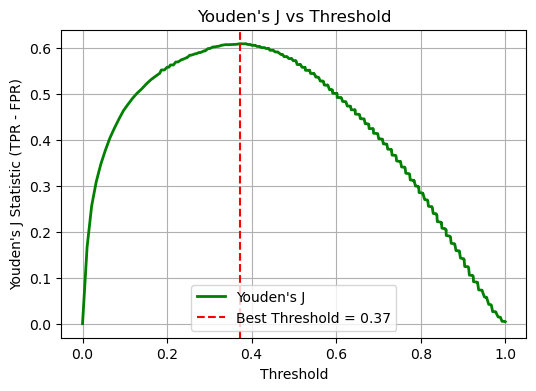

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC and J scores
fpr, tpr, roc_thresholds = roc_curve(oof_true, oof_proba)
j_scores = tpr - fpr  # Formula derived from the definition of Youden's J 

# Find best threshold again (if not already defined)
best_thresh = roc_thresholds[np.argmax(j_scores)]
best_j = j_scores[np.argmax(j_scores)]

# Plot Youden’s J statistic vs threshold
plt.figure(figsize=(6, 4))
plt.plot(roc_thresholds, j_scores, color="green", lw=2, label="Youden's J")
plt.axvline(x=best_thresh, color="red", linestyle="--", label=f'Best Threshold = {best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("Youden's J Statistic (TPR - FPR)")
plt.title("Youden's J vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

0.9923581140122751


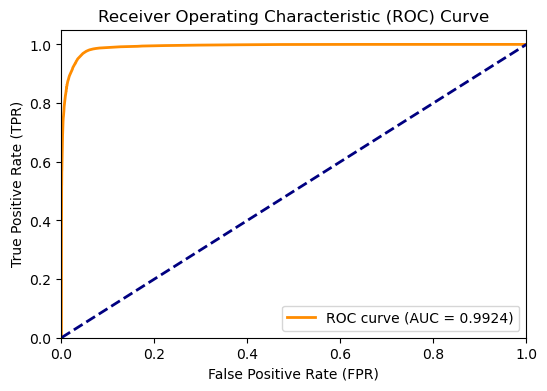

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
Y_pred_proba = best_rf.predict_proba(oof_X_test)[:, 1]  # Validate on out-of-fold data points 
auc = roc_auc_score(oof_true, Y_pred_proba)
print(auc)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(oof_true, Y_pred_proba)
# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

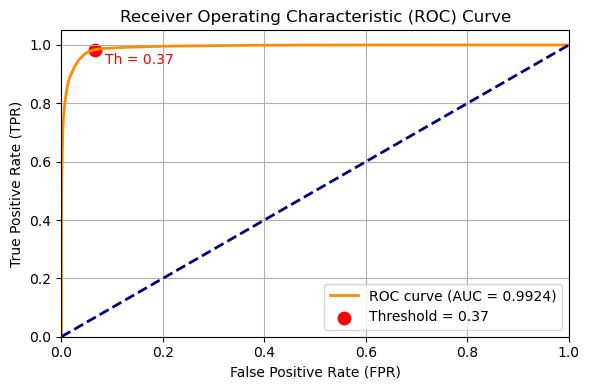

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on full training data 
Y_pred_proba = best_rf.predict_proba(oof_X_test)[:, 1] # Change for X_test

# Compute AUC
auc_value = roc_auc_score(oof_true, Y_pred_proba) # Change to oof_true for Y 
#print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(oof_true, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Locate point on ROC corresponding to your optimized threshold
threshold_idx = np.argmin(np.abs(thresholds - best_thresh))
fpr_opt = fpr[threshold_idx]
tpr_opt = tpr[threshold_idx]

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate optimized threshold point
plt.scatter(fpr_opt, tpr_opt, color='red', s=80, label=f'Threshold = {best_thresh:.2f}')
plt.text(fpr_opt + 0.02, tpr_opt - 0.05, f'Th = {best_thresh:.2f}', color='red')

# Labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

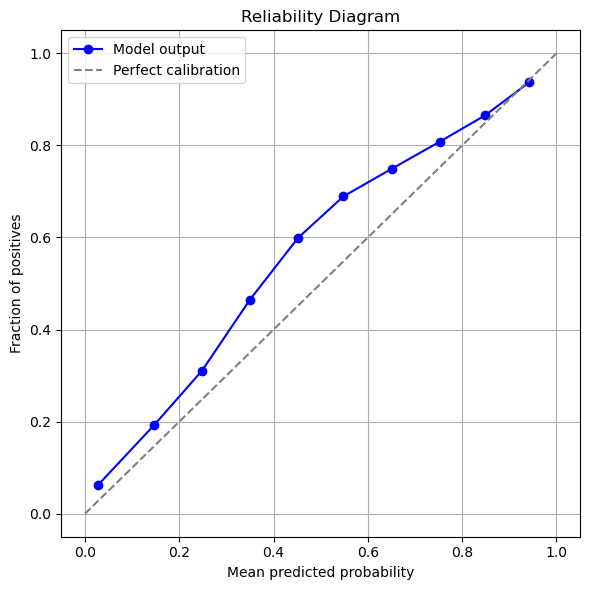

In [19]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Compute calibration curve (reliability diagram)
prob_true, prob_pred = calibration_curve(oof_true, oof_proba, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model output', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
for i, (train_idx, test_idx) in enumerate(folds):
    print(f"Fold {i}: Train size = {len(train_idx)}, Test size = {len(test_idx)}")

Fold 0: Train size = 31789, Test size = 7437
Fold 1: Train size = 31138, Test size = 8088
Fold 2: Train size = 31578, Test size = 7648
Fold 3: Train size = 31217, Test size = 8009
Fold 4: Train size = 31182, Test size = 8044


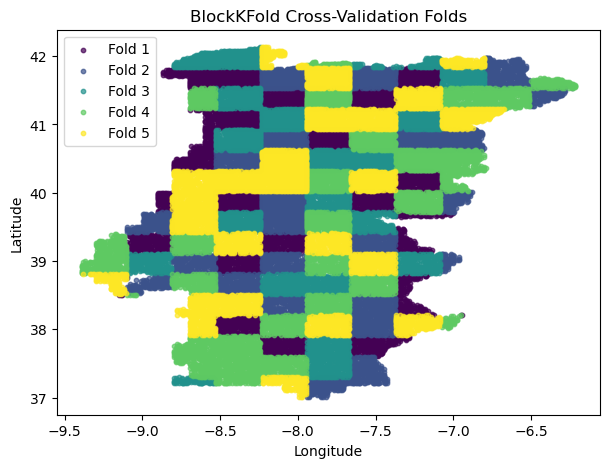

In [21]:
# Define colors for visualization
colors = plt.cm.viridis(np.linspace(0, 1, n_splits))  # 5 folds

# Plot each fold separately
plt.figure(figsize=(7, 5))
for fold_number in range(len(folds)):
    mask = fold_labels == fold_number  # Select points belonging to this fold
    plt.scatter(coordinates[mask, 0], coordinates[mask, 1], 
                color=colors[fold_number], s=10, label=f"Fold {fold_number+1}", alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("BlockKFold Cross-Validation Folds")
plt.legend()
plt.show()

In [22]:
# Change the projection
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

#Create GeoDataFrame
geometry = [Point(xy) for xy in coordinates]
gdf = gpd.GeoDataFrame({'fold': fold_labels}, geometry=geometry, crs="EPSG:3763")

#Reproject to EPSG:3763 (Portugal TM06)
gdf = gdf.to_crs(epsg=3763)

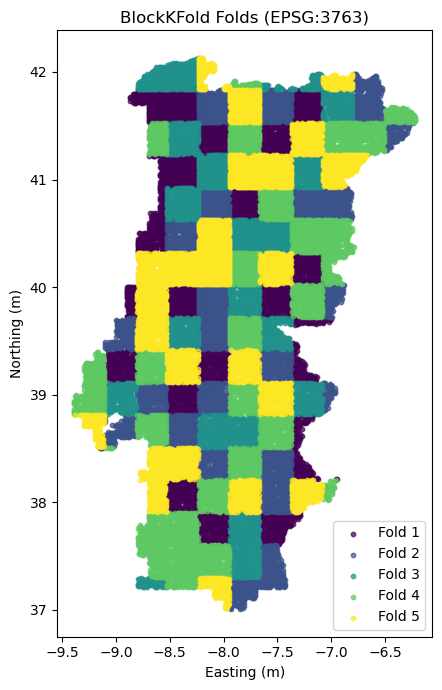

In [23]:
# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(fold_labels))))

# Plot using GeoPandas, which respects CRS
fig, ax = plt.subplots(figsize=(9, 7))
for fold_number in range(len(np.unique(fold_labels))):
    fold_gdf = gdf[gdf['fold'] == fold_number]
    fold_gdf.plot(ax=ax, color=colors[fold_number], markersize=10, label=f"Fold {fold_number + 1}", alpha=0.7)

ax.set_title("BlockKFold Folds (EPSG:3763)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend()
plt.tight_layout()
plt.show()

In [24]:
# Check the number of folds created 
f = list(cv.split(coordinates))
num_folds = len(f)
print(num_folds)
# Store the size of each test fold
fold_sizes = [len(test) for _, test in f]
# Compute the total dataset size 
total_points = len(coordinates)
# Compute percentage for each fold 
fold_percentages = [size / total_points * 100 for size in fold_sizes]
print(fold_percentages)
# Compute may/min size ratio 
fold_ratio = max(fold_sizes) / min(fold_sizes) 
print(f"\nLargest fold is {fold_ratio:.2f} times bigger than the smallest fold.")

5
[18.959363687350226, 20.618977208994036, 19.49727221740682, 20.4175801764136, 20.506806709835313]

Largest fold is 1.09 times bigger than the smallest fold.


ssrd_mean              0.224290
tp_mean                0.135662
t2m_mean               0.067970
rh_mean                0.054657
sp_mean                0.053331
slope                  0.050861
d2m_mean               0.050673
wind_speed_mean        0.050052
lst_day_mean           0.048794
wind_direction_mean    0.043605
smi_mean               0.042429
dem                    0.041163
lst_night_mean         0.033093
ndvi_mean              0.029840
roads_distance         0.029524
aspect                 0.023982
curvature              0.020074
dtype: float64


<Axes: >

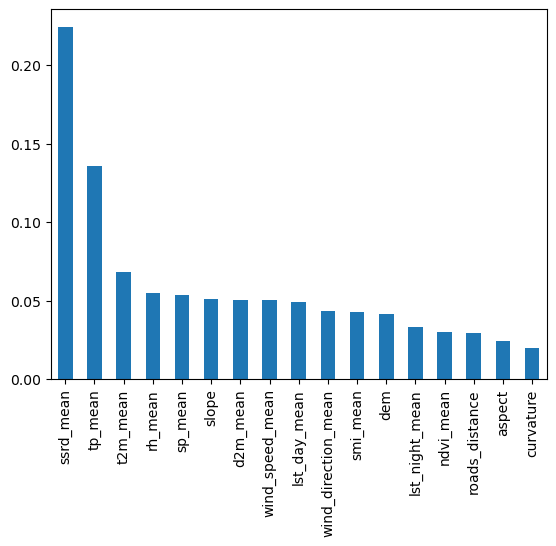

In [25]:
# Feature names of the original dataframe 
feature_names = input.columns

# Convert X_test to DataFrame (if not already a DataFrame)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Now access the columns attribute
feature_imp = pd.Series(best_rf.feature_importances_, index=X_test_df.columns).sort_values(ascending=False)

# Print and plot the feature importance
print(feature_imp)
feature_imp.plot(kind='bar')

In [26]:
optimal_threshold = 0.37
# Predict on test using optimal threshold
y_test_proba = best_rf.predict_proba(unseen_test)[:, 1]
Y_test_unseen_pred = (y_test_proba >= optimal_threshold).astype(int)

test_accuracy = accuracy_score(Y_unseen_test, Y_test_unseen_pred)
print(test_accuracy)

0.7477579706431421


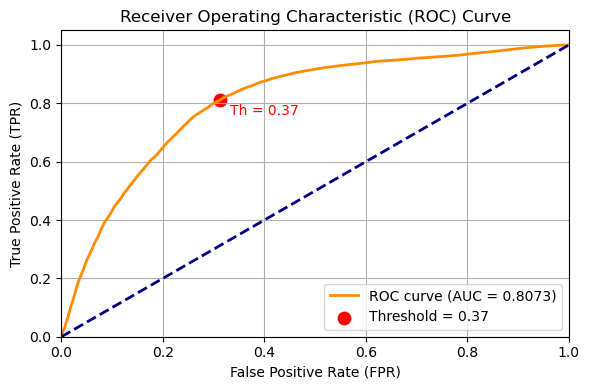

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on full training data 
Y_pred_proba = best_rf.predict_proba(unseen_test)[:, 1]

# Compute AUC
auc_value = roc_auc_score(Y_unseen_test, Y_pred_proba)
#print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_unseen_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Locate point on ROC corresponding to your optimized threshold
threshold_idx = np.argmin(np.abs(thresholds - best_thresh))
fpr_opt = fpr[threshold_idx]
tpr_opt = tpr[threshold_idx]

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate optimized threshold point
plt.scatter(fpr_opt, tpr_opt, color='red', s=80, label=f'Threshold = {best_thresh:.2f}')
plt.text(fpr_opt + 0.02, tpr_opt - 0.05, f'Th = {best_thresh:.2f}', color='red')

# Labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

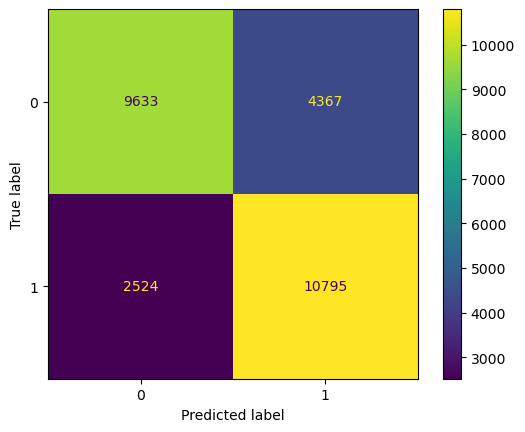

In [28]:
# Confusion matrix 
cm = confusion_matrix(Y_unseen_test, Y_test_unseen_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Susceptibility Map

In [29]:
# Load data - Static Map 
data = pd.read_csv('/users/aleclerc/work/drive/data_mesogeos_static_map_1722.csv')
print(data.head(1))

           y         x  spatial_ref   d2m_mean  lst_day_mean  lst_night_mean  \
0  42.131099 -8.252199            0  284.26492      294.8311       284.33823   

   ndvi_mean   rh_mean  smi_mean   sp_mean  ssrd_mean   t2m_mean   tp_mean  \
0   0.704738  0.600729   0.73179  95863.13  7586902.0  290.62735  0.005336   

   wind_direction_mean  wind_speed_mean        dem  aspect  curvature  \
0            188.91997         3.052264  88.413734  303.26  -19116.58   

   roads_distance     slope  
0        0.600729  4.188464  



- Other limitations for the static case which might explain mediocre perfomance: some features have been left out for the sake of comparison (static VS dynamic)
- Same thresholds for accuracy and Youden's J optimization - same as the dynamic case; However, overfits the validation set alittle bit, which does not happen in the dynamic case (perfect threshold was found for the testing set)



In [30]:
static = pd.read_csv('/users/aleclerc/work/drive/data_mesogeos_static_map_1722.csv')

In [31]:
# Save coordinates for matching length when plotting 
test_coordinates = static.to_numpy()  # Numpy array already 
longitudes, latitudes = test_coordinates[:, 1], test_coordinates[:, 0] 

In [32]:
drop = ['spatial_ref','y','x']
static = static.drop(columns=drop)
static = static.to_numpy()

In [33]:
# Transform outputs into probabilities 
proba = best_rf.predict_proba(static)
print(proba) 
susceptibility_map_00 = proba[:, 0]  # Probability of not burning
susceptibility_map_11 = proba[:, 1]  # Probability of burning
print(susceptibility_map_11.shape)

[[0.51612903 0.48387097]
 [0.17204301 0.82795699]
 [0.38709677 0.61290323]
 ...
 [0.76344086 0.23655914]
 [0.79569892 0.20430108]
 [0.79569892 0.20430108]]
(92202,)


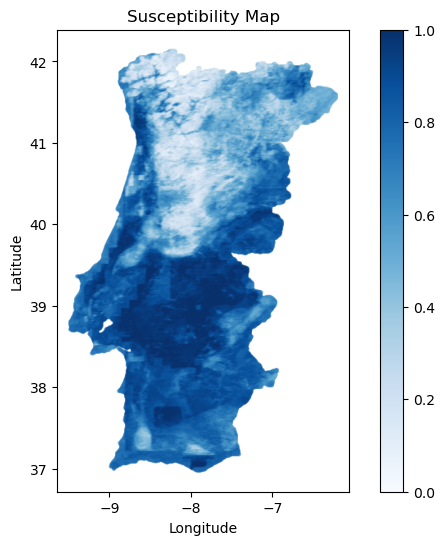

In [34]:
# Plotting 
from shapely.geometry import Point
#test_coordinates = data1722.to_numpy()  # Numpy array already 
#longitudes, latitudes = test_coordinates[:, 2], test_coordinates[:, 1] # 21 and 22  are the coordinatesr indexes 
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(longitudes, latitudes)]
gdf0 = gpd.GeoDataFrame({'susceptibility': susceptibility_map_00}, geometry=geometry, crs="EPSG:3763")
# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
gdf0.plot(column='susceptibility', cmap='Blues', markersize=4, alpha=0.3, legend=True, ax=ax)
ax.set_title("Susceptibility Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

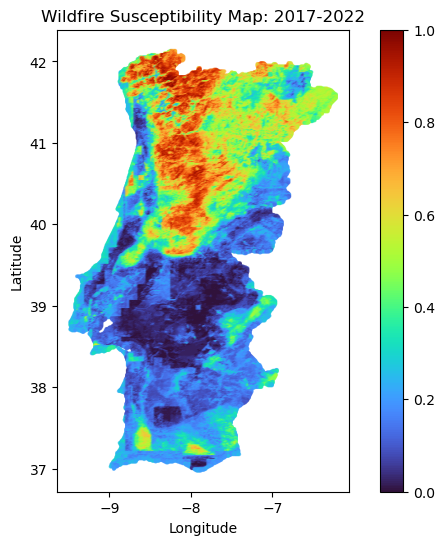

In [35]:
gdf1 = gpd.GeoDataFrame({'susceptibility': susceptibility_map_11}, geometry=geometry, crs="EPSG:3763")  # Include coordinates with appropriate projection in the data frame 
# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
gdf1.plot(column='susceptibility', cmap='turbo', markersize=3, alpha=0.6, legend=True, ax=ax)
ax.set_title("Wildfire Susceptibility Map: 2017-2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Map validation

In [36]:
validation = pd.read_csv('/users/aleclerc/work/drive/data_static_map_validation.csv')
validation = validation['burned_areas']

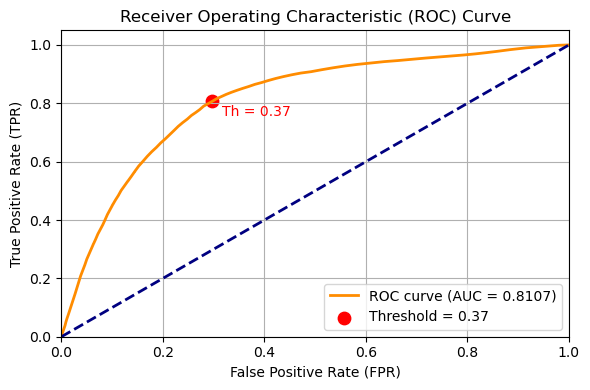

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities on full training data 
Y_pred_proba = best_rf.predict_proba(static)[:, 1]

# Compute AUC
auc_value = roc_auc_score(validation, Y_pred_proba)
#print(f"AUC: {auc_score:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(validation, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# Locate point on ROC corresponding to your optimized threshold
threshold_idx = np.argmin(np.abs(thresholds - best_thresh))
fpr_opt = fpr[threshold_idx]
tpr_opt = tpr[threshold_idx]

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate optimized threshold point
plt.scatter(fpr_opt, tpr_opt, color='red', s=80, label=f'Threshold = {best_thresh:.2f}')
plt.text(fpr_opt + 0.02, tpr_opt - 0.05, f'Th = {best_thresh:.2f}', color='red')

# Labels and formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Accuracy on static map 

optimal_threshold = 0.37
# Predict on test using optimal threshold
y_map_proba = best_rf.predict_proba(static)[:, 1]
Y_map_unseen_pred = (y_map_proba >= optimal_threshold).astype(int)

map_accuracy = accuracy_score(validation, Y_map_unseen_pred)
print(map_accuracy)

0.7179236892909048


Limitations:

   - Poorer performance with static features only
   - Some features have been removed for the sake of comparison, which might affect model's performance
   -  Validation set (map): sample, not all fire points could be taken into account (data availability)

In [ ]:
gdf1 = gpd.GeoDataFrame({'susceptibility': susceptibility_map_11}, geometry=geometry, crs="EPSG:3763")  # Include coordinates with appropriate projection in the data frame 
# Plot using Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
gdf1.plot(column='susceptibility', cmap='turbo', markersize=3, alpha=0.6, legend=True, ax=ax)
ax.set_title("Wildfire Susceptibility Map: 2017-2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
M